In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **1. Preparing data**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # 이진화
])

In [ ]:
train_dataset = datasets.MNIST(root='../data', train = True,
                               transform = transform, download = True)
test_dataset = datasets.MNIST(root='../data', train = False,
                              transform = transform, download = True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle = False)

# **2. Modeling**

## **2-1. VAE**

In [ ]:
class VAE(nn.Module):
    def __init__(self, architecture, latent_dim, k):
        super(VAE, self).__init__()
        self.architecture = architecture
        self.latent_dim = latent_dim
        self.k = k  # k 저장

        if architecture == 1:
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(28*28, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh()
            )
            self.fc_mean = nn.Linear(200, self.latent_dim)
            self.fc_logvar = nn.Linear(200, self.latent_dim)

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(self.latent_dim, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh(),
                nn.Linear(200, 28*28),
                nn.Sigmoid()
            )

        elif architecture == 2:
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(28*28, 200),
                nn.Tanh(),
                nn.Linear(200, 100),
                nn.Tanh()
            )
            self.fc_mean1 = nn.Linear(100, 100)
            self.fc_logvar1 = nn.Linear(100, 100)
            self.fc_mean2 = nn.Linear(100, self.latent_dim)
            self.fc_logvar2 = nn.Linear(100, self.latent_dim)

            self.middle = nn.Sequential(
                nn.Linear(self.latent_dim, 100),
                nn.Tanh(),
                nn.Linear(100, 100),
                nn.Tanh()
            )

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(100, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh(),
                nn.Linear(200, 28*28),
                nn.Sigmoid()
            )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + std * epsilon

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten input

        if self.architecture == 1:
            # Encoding
            h = self.encoder(x)
            mu_z = self.fc_mean(h)
            log_var_z = self.fc_logvar(h)

            # Reparameterizing
            z = self.reparameterize(mu_z, log_var_z).unsqueeze(1).repeat(1, self.k, 1)  # (batch_size, k, latent_dim)

            # Decoding
            x_hat = self.decoder(z)
            return x_hat, z, mu_z, log_var_z

        elif self.architecture == 2:
            h = self.encoder(x)
            mu_z1 = self.fc_mean1(h)
            log_var_z1 = self.fc_logvar1(h)
            z1 = self.reparameterize(mu_z1, log_var_z1)
            h = self.middle(z1)
            mu_z2 = self.fc_mean2(h)
            log_var_z2 = self.fc_logvar2(h)
            z2 = self.reparameterize(mu_z2, log_var_z2).unsqueeze(1).repeat(1, self.k, 1)

            x_hat = self.decoder(z2)
            return x_hat, z2, mu_z2, log_var_z2

In [ ]:
class IWAE(VAE):
    pass  # IWAE는 VAE를 상속받아 별도 정의 없이 사용 가능

# **3. Loss 정의**

## **3-1. Training**
- VAE와 IWAE의 lower bound를 정의하고, 이들을 최적화하는 방향으로 학습

### **VAE**
- VAE는 **Evidence Lower Bound (ELBO)**를 최대화하는 방식으로 학습됨
- ELBO는 아래와 같은 형태임:
$$\text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log p(x|h)\right] - \text{KL}(q(h|x) \| p(h))$$
---
${L}^{\text{VAE}}{(x)}   =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log \frac{p_(x, z_k)}{q_(z_i | x)} \right] =  \frac{1}{k} \left[ \sum_{i=1}^{k}\frac{p_(x, z_k)}{q_(z_i | x)}  \right] \\ = -D_{KL}(q_(z_| x)||p(z)) + \frac{1}{k} \sum_{i=1}^{k} (\log p(x|z_i)) $

In [ ]:
def vae_loss(x, x_hat, mu_z, log_var_z):
    batch_size, k, _ = x_hat.shape
    x = x.view(batch_size, 1, 28*28).expand(-1, k, -1) # (batch_size, k, 28*28)

    # Reconstruction loss: Binary Cross-Entropy
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') / k

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())

    # ELBO = - (Reconstruction loss + KL divergence)
    elbo_vae = recon_loss + kl_divergence

    # Return the negative ELBO
    return elbo_vae

### **IWAE**
- IWAE는 **Importance Weighted Autoencoder**로, VAE와 유사한 구조를 가지지만, 더 높은 표현 능력을 갖도록 샘플링된 $k$개의 샘플에 가중치를 부여함
- ${L}^{\text{IWAE}}_{\text{k}}{(x)}   \\ =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log (\frac{1}{k} \sum_{i=1}^{k} \frac{p_(x, z_k)}{q_(z_i | x)}) \right]   \\ =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log (\frac{1}{k} \sum_{i=1}^{k} w_i) \right]$


In [ ]:
def iwae_loss(x, x_hat, mu_z, log_var_z):
    batch_size, k, _ = x_hat.shape
    x = x.view(batch_size, 1, 28*28).expand(-1, k, -1)

    # Reshape mu_z and log_var_z
    mu_z = mu_z.unsqueeze(1)            # (batch_size, 1, latent_dim)
    log_var_z = log_var_z.unsqueeze(1)  # (batch_size, 1, latent_dim)

    # log p(x|z)
    log_p_x_given_z = -F.binary_cross_entropy(x_hat, x, reduction='none').sum(dim=2)
    # log p(z)
    log_p_z = -0.5 * torch.sum(mu_z.pow(2), dim=2)
    # log q(z|x)
    log_q_z_given_x = -0.5 * (log_var_z - torch.pow(mu_z, 2) - torch.exp(log_var_z)).sum(dim=2)

    # Importance weights: log p(x|z) + log p(z) - log q(z|x)
    log_w = log_p_x_given_z + log_p_z - log_q_z_given_x

    # IWAE ELBO
    elbo_iwae = (torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(k))).sum()

    return -elbo_iwae

## **3-2. Testing**
- Negative Log Likelihood 활용
- 이때, true likelihood를 계산할 수는 없음
  - 근사치 활용
  - IWAE의 $L_{5000}$ 활용


In [ ]:
def calculate_nll(model, test_loader, k=5000):
    model.eval()
    nll = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            model.k = k  # 테스트 시 k 값 설정
            x_hat, _, mu_z, log_var_z = model(x)
            loss = iwae_loss(x, x_hat, mu_z, log_var_z)
            nll += loss.item()
    nll /= len(test_loader.dataset)
    return nll

# **4. Training & Testing**

## **4-1. Training**

In [ ]:
def train(model, optimizer, data_loader, num_epochs=10, k=1):
    model.k = k  # 학습 시 k 값 설정
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, _ in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, z, mu_z, log_var_z = model(x)
            if isinstance(model, IWAE):
                loss = iwae_loss(x, x_hat, mu_z, log_var_z)
            else:
                loss = vae_loss(x, x_hat, mu_z, log_var_z)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

## **4-2. Testing**

**활성 unit 개수 측정**

In [ ]:
def compute_active_units(model, data_loader, threshold=1e-2):
    model.eval()
    active_units = torch.zeros(model.latent_dim).to(device)
    with torch.no_grad():
        mu_zs = []

        for x, _ in data_loader:
            x = x.to(device)
            _, _, mu_z, _ = model(x)
            mu_zs.append(mu_z.cpu().numpy())

        mu_zs = np.concatenate(mu_zs, axis=0)
        variances = np.var(mu_zs, axis=0)
        active_units = np.sum(variances > threshold)

    return active_units

In [ ]:
def evaluate(model, data_loader, k=5000):
    nll = calculate_nll(model, data_loader, k=k)
    active_units = compute_active_units(model, data_loader)
    return nll, active_units

# **5. RUN!!**

**시각화**

In [ ]:
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        x_hat, _, _, _ = model(x)

        x_hat = x_hat.mean(dim=1)  # k개의 샘플을 평균내어 하나의 이미지를 얻음

        x = x.cpu().numpy()
        x_hat = x_hat.cpu().numpy()

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
            axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            axes[1, i].imshow(x_hat[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title('Reconstruction')
            axes[1, i].axis('off')

        plt.show()

In [ ]:
def run(architecture=1, k_train=5, k_test=5000):
    vae = VAE(architecture=architecture, latent_dim=50, k=k_train).to(device)
    iwae = IWAE(architecture=architecture, latent_dim=50, k=k_train).to(device)

    vae_optimizer = optim.Adam(vae.parameters(), lr=0.01)
    iwae_optimizer = optim.Adam(iwae.parameters(), lr=0.01)

    ## === VAE ===
    print(f"Training VAE with architecture {architecture}...")
    elbo_values_vae = train(vae, vae_optimizer, train_loader, num_epochs = 200, k=k_train)
    print(f"Evaluating VAE with architecture {architecture}...")
    nll_vae, active_units_vae = evaluate(vae, test_loader, k=k_test)
    print(f"VAE NLL with architecture {architecture} and k={k_test}: ", nll_vae)
    print(f"VAE Active Units with architecture {architecture} and k={k_test}: ", active_units_vae)

    print()

    ## === IWAE ===
    print(f"Training IWAE with architecture {architecture} and k={k_train}...")
    elbo_values_iwae = train(iwae, iwae_optimizer, train_loader, num_epochs = 200, k=k_train)
    print(f"Evaluating IWAE with architecture {architecture} and k={k_test}...")
    nll_iwae, active_units_iwae = evaluate(iwae, test_loader, k=k_test)
    print(f"IWAE NLL with architecture {architecture} and k={k_test}: ", nll_iwae)
    print(f"IWAE Active Units with architecture {architecture} and k={k_test}: ", active_units_iwae)

    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(elbo_values_vae, label=f'VAE Architecture {architecture} (k={k_train})', color='blue')
    plt.plot(elbo_values_iwae, label=f'IWAE Architecture {architecture} (k={k_train})', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves for Architecture {architecture} (k={k_train})')
    plt.legend()
    plt.show()

    visualize_reconstruction(vae, test_loader)
    print()
    visualize_reconstruction(iwae, test_loader)

## **5-1. Case 1**
- model = 1
- k = 1

In [ ]:
run(architecture = 1, k_train = 1, k_test = 5000)

## **5-2. Case 2**
- model = 1
- k = 5

Training VAE with architecture 1...
Epoch [1/100], Loss: 163.6307
Epoch [2/100], Loss: 117.9100
Epoch [3/100], Loss: 108.0817
Epoch [4/100], Loss: 103.1357
Epoch [5/100], Loss: 99.7011
Epoch [6/100], Loss: 97.5416
Epoch [7/100], Loss: 95.7293
Epoch [8/100], Loss: 94.3811
Epoch [9/100], Loss: 93.2869
Epoch [10/100], Loss: 92.5338
Epoch [11/100], Loss: 91.7909
Epoch [12/100], Loss: 91.2919
Epoch [13/100], Loss: 90.6841
Epoch [14/100], Loss: 90.3053
Epoch [15/100], Loss: 90.0257
Epoch [16/100], Loss: 89.6031
Epoch [17/100], Loss: 89.2974
Epoch [18/100], Loss: 88.9737
Epoch [19/100], Loss: 88.8326
Epoch [20/100], Loss: 88.5877
Epoch [21/100], Loss: 88.3224
Epoch [22/100], Loss: 88.0939
Epoch [23/100], Loss: 87.9673
Epoch [24/100], Loss: 87.8438
Epoch [25/100], Loss: 87.6395
Epoch [26/100], Loss: 87.4958
Epoch [27/100], Loss: 87.4089
Epoch [28/100], Loss: 87.2959
Epoch [29/100], Loss: 87.1518
Epoch [30/100], Loss: 87.0357
Epoch [31/100], Loss: 87.0074
Epoch [32/100], Loss: 86.8286
Epoch [33

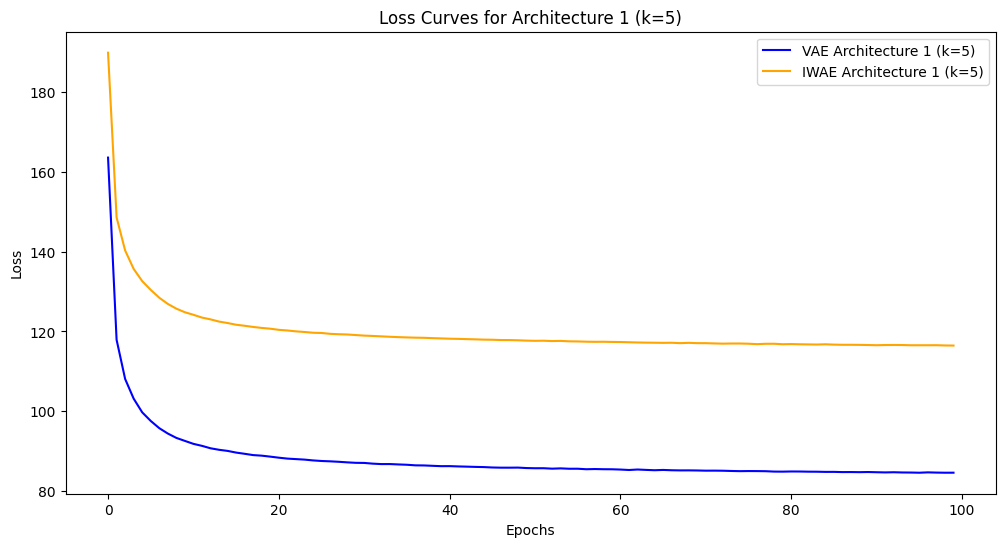

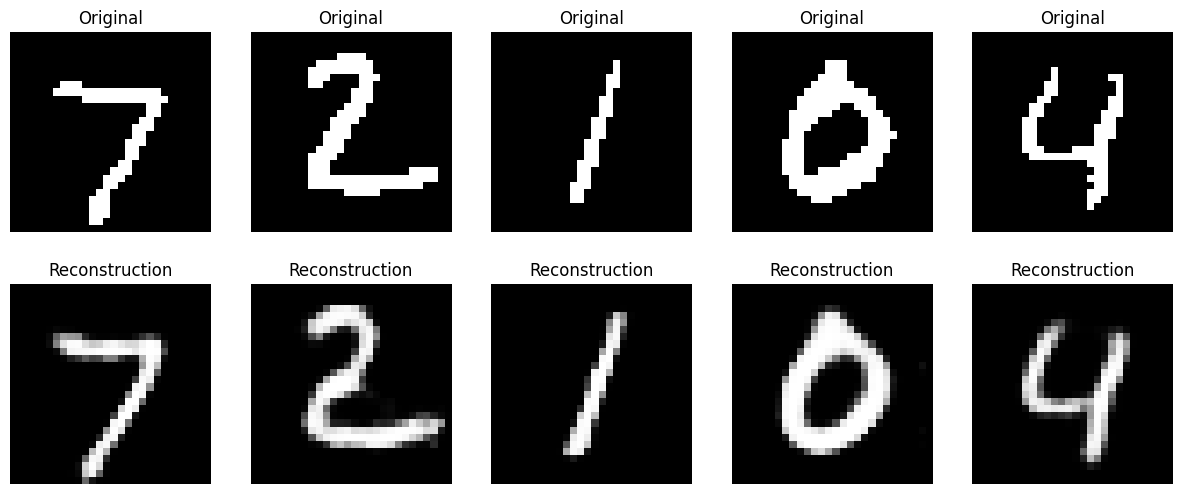

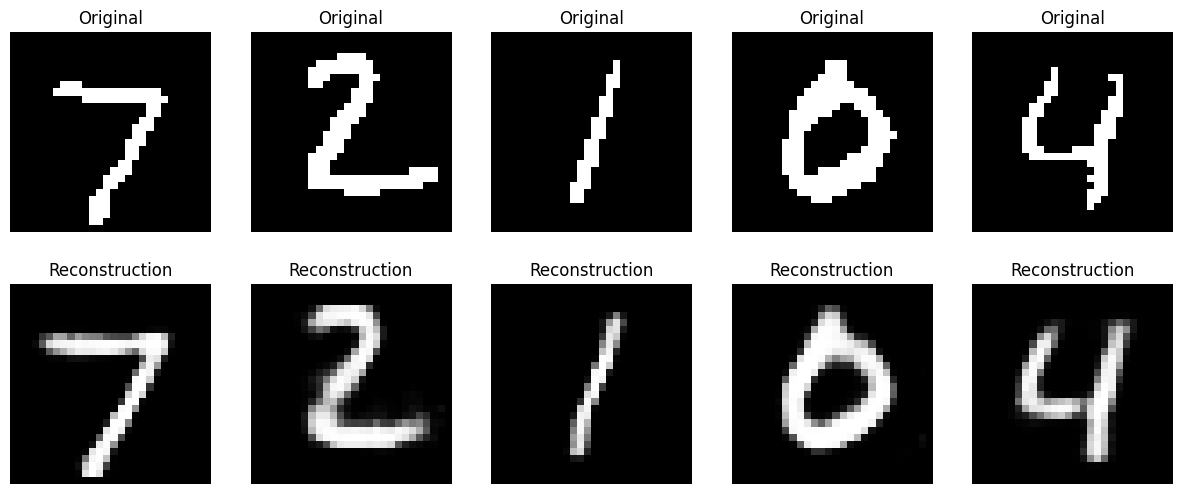

In [ ]:
run(architecture = 1, k_train = 5, k_test = 5000)

- Training 시에는 VAE에 비해 IWAE의 loss가 높게 측정된다.
- 그러나, 이후 k = 5000에서의 NLL approximate로 테스트 결과, 논문에서 제시한 바와 같이 IWAE의 loss가 더 낮게 측정된다.

## **5-3. Case 3**
- model = 1
- k = 50

In [ ]:
run(architecture = 1, k_train = 50, k_test = 5000)

## **5-4. Case 4**
- model = 2
- k = 1

In [ ]:
run(architecture = 2, k_train = 1, k_test = 5000)

## **5-5. Case 5**
- model = 2
- k = 5

In [ ]:
run(architecture = 2, k_train = 5, k_test = 5000)

## **5-6. Case 6**
- model = 2
- k = 50

In [ ]:
run(architecture = 2, k_train = 50, k_test = 5000)